# Tips：
1. 运行前检查下package是否都已经pip install或conda install。

2. 确保notebook所在的文件夹下有老师提供的文件 enron_mail_20150507.tar.gz

    下载链接：https://www.cs.cmu.edu/~enron/

3. 第一次运行结束后，需要 __取消__ upzip file 和 transfrom data to dataframe的 __%%script false__ 注释，加上这行代码是为了防止每次run all的时候重复解压并生成CSV。

4. 解压后的文件以及CSV，会生成在notebook所在的文件夹下。

# Import Needed Libraries

In [3]:
# import needed libraries

# System libraries for file and directory manipulation
import tarfile
import os
from email import message_from_string

# Data manipulation libraries
import numpy as np
import string
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set_style('darkgrid')
import re
from datetime import datetime
from dateutil import tz
import networkx as nx
import nltk
import wordcloud
import plotly.express as px
from plotly import graph_objects as go

# Machine learning and NLP libraries
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import normalize
from sklearn.cluster import KMeans
from sklearn.decomposition import TruncatedSVD
from sklearn import metrics
import scipy as sp
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer, WordNetLemmatizer

In [4]:
from nltk.corpus import stopwords
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to /Users/suwanxi/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /Users/suwanxi/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/suwanxi/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

# Unzip File

In [6]:
%%script false

# Extract the tar.gz file. Once finished, pls uncomment the following code prevent duplicate generation
with tarfile.open('enron_mail_20150507.tar.gz', 'r:gz') as tar:
    tar.extractall('enron_data') 

/var/folders/ms/27ly2n1s1c34z6ysvnjb6wr00000gn/T/ipykernel_1117/703942358.py:5: DeprecationWarning: Python 3.14 will, by default, filter extracted tar archives and reject files or modify their metadata. Use the filter argument to control this behavior.
  tar.extractall('enron_data')


# Transform Data to Dataframe and Save As CSV

In [8]:
#%%script false

# The folder path where the Enron dataset is located
dataset_dir = 'enron_data/maildir'
output_file = 'enron_dataset.csv'

# Create an empty DataFrame to hold the file and message columns
data = {'file': [], 'message': []}

# Traverse folders starting from 'maildir'
for root, dirs, files in os.walk(dataset_dir):
    for file_name in files:
        file_path = os.path.join(root, file_name)

        # Calculate the relative path from the 'maildir' directory
        relative_path = os.path.relpath(file_path, dataset_dir).replace('\\', '/')

        # Open and parse the email
        with open(file_path, 'r', encoding='utf-8', errors='ignore') as email_file:
            raw_email = email_file.read()
            email = message_from_string(raw_email)

            # Combine all fields into the message column
            message = f"Message-ID: {email.get('Message-ID')}\n" \
                      f"Date: {email.get('Date')}\n" \
                      f"From: {email.get('From')}\n" \
                      f"To: {email.get('To')}\n" \
                      f"Subject: {email.get('Subject')}\n" \
                      f"Mime-Version: {email.get('Mime-Version')}\n" \
                      f"Content-Type: {email.get('Content-Type')}\n" \
                      f"Content-Transfer-Encoding: {email.get('Content-Transfer-Encoding')}\n" \
                      f"X-From: {email.get('X-From')}\n" \
                      f"X-To: {email.get('X-To')}\n" \
                      f"X-cc: {email.get('X-cc')}\n" \
                      f"X-bcc: {email.get('X-bcc')}\n" \
                      f"X-Folder: {email.get('X-Folder')}\n" \
                      f"X-Origin: {email.get('X-Origin')}\n" \
                      f"X-FileName: {email.get('X-FileName')}\n" \
                      f"Body: {email.get_payload()}\n"

            # Append the relative file path and the raw email content to the data dictionary
            data['file'].append(relative_path)
            data['message'].append(message)

# Convert to DataFrame
enron_df = pd.DataFrame(data)

# Save as CSV file
enron_df.to_csv(output_file, index=False)


# Data Preparation

In [10]:
df = pd.read_csv("enron_dataset.csv")

In [43]:
#%%script false
df.head()

,file,message
0,arnold-j/notes_inbox/36.,Message-ID: <17334447.1075857585446.JavaMail.e...
1,arnold-j/notes_inbox/19.,Message-ID: <19171686.1075857585034.JavaMail.e...
2,arnold-j/notes_inbox/50.,Message-ID: <29887033.1075857630725.JavaMail.e...
3,arnold-j/notes_inbox/3.,Message-ID: <29084893.1075849630138.JavaMail.e...
4,arnold-j/notes_inbox/9.,Message-ID: <30248874.1075857584813.JavaMail.e...


In [45]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 517401 entries, 0 to 517400
Data columns (total 2 columns):
 #   Column   Non-Null Count   Dtype 
---  ------   --------------   ----- 
 0   file     517401 non-null  object
 1   message  517401 non-null  object
dtypes: object(2)
memory usage: 7.9+ MB


In [47]:
#%%script false
emails = list(map(message_from_string,df['message']))
emails

 ...]

In [49]:
#%%script false
headings  = emails[0].keys()
headings

['Message-ID',
 'Date',
 'From',
 'To',
 'Subject',
 'Mime-Version',
 'Content-Type',
 'Content-Transfer-Encoding',
 'X-From',
 'X-To',
 'X-cc',
 'X-bcc',
 'X-Folder',
 'X-Origin',
 'X-FileName',
 'Body']

In [51]:
#%%script false

for head in headings:
    df[head] = [email[head] for email in emails]

In [52]:
#%%script false

df.head()

,file,message,Message-ID,Date,From,To,Subject,Mime-Version,Content-Type,Content-Transfer-Encoding,X-From,X-To,X-cc,X-bcc,X-Folder,X-Origin,X-FileName,Body
0,arnold-j/notes_inbox/36.,Message-ID: <17334447.1075857585446.JavaMail.e...,<17334447.1075857585446.JavaMail.evans@thyme>,"Thu, 16 Nov 2000 09:30:00 -0800 (PST)",msagel@home.com,jarnold@enron.com,Status,1.0,text/plain; charset=ANSI_X3.4-1968,7bit,"""Mark Sagel"" <msagel@home.com>","""John Arnold"" <jarnold@enron.com>",,,\John_Arnold_Dec2000\Notes Folders\Notes inbox,Arnold-J,Jarnold.nsf,John:
1,arnold-j/notes_inbox/19.,Message-ID: <19171686.1075857585034.JavaMail.e...,<19171686.1075857585034.JavaMail.evans@thyme>,"Fri, 8 Dec 2000 05:05:00 -0800 (PST)",slafontaine@globalp.com,john.arnold@enron.com,re:summer inverses,1.0,text/plain; charset=us-ascii,7bit,slafontaine@globalp.com,John.Arnold@enron.com,,,\John_Arnold_Dec2000\Notes Folders\Notes inbox,Arnold-J,Jarnold.nsf,i suck-hope youve made more money in natgas la...
2,arnold-j/notes_inbox/50.,Message-ID: <29887033.1075857630725.JavaMail.e...,<29887033.1075857630725.JavaMail.evans@thyme>,"Tue, 15 May 2001 09:43:00 -0700 (PDT)",iceoperations@intcx.com,"icehelpdesk@intcx.com, internalmarketing@intcx...",The WTI Bullet swap contracts,1.0,text/plain; charset=us-ascii,7bit,ICE Operations <ICEOperations@intcx.com>,"**ICEHELPDESK <**ICEHELPDESK@intcx.com>, **Int...",,,\John_Arnold_Jun2001\Notes Folders\Notes inbox,Arnold-J,Jarnold.nsf,"Hi,"
3,arnold-j/notes_inbox/3.,Message-ID: <29084893.1075849630138.JavaMail.e...,<29084893.1075849630138.JavaMail.evans@thyme>,"Mon, 27 Nov 2000 01:49:00 -0800 (PST)",jeff.youngflesh@enron.com,"anthony.gilmore@enron.com, colleen.koenig@enro...",Invitation: EBS/GSS Meeting w/Bristol Babcock ...,1.0,text/plain; charset=us-ascii,7bit,Jeff Youngflesh,"Anthony Gilmore, Colleen Koenig, Jennifer Stew...",,,\John_Arnold_Nov2001\Notes Folders\Notes inbox,ARNOLD-J,jarnold.nsf,Conference Room TBD.
4,arnold-j/notes_inbox/9.,Message-ID: <30248874.1075857584813.JavaMail.e...,<30248874.1075857584813.JavaMail.evans@thyme>,"Tue, 12 Dec 2000 09:33:00 -0800 (PST)",caroline.abramo@enron.com,mike.grigsby@enron.com,Harvard Mgmt,1.0,text/plain; charset=us-ascii,7bit,Caroline Abramo,Mike Grigsby,John Arnold,,\John_Arnold_Dec2000\Notes Folders\Notes inbox,Arnold-J,Jarnold.nsf,Mike- I have their trader coming into the offi...


# Data Cleaning

In [53]:
def getItems(type, messages):
    list = []
    
    for i, message in (messages.items()):
        e = message_from_string(message)
        # string type to email message type
        list.append(e.get(type))
       
    return list

In [54]:
#%%script false

headings

['Message-ID',
 'Date',
 'From',
 'To',
 'Subject',
 'Mime-Version',
 'Content-Type',
 'Content-Transfer-Encoding',
 'X-From',
 'X-To',
 'X-cc',
 'X-bcc',
 'X-Folder',
 'X-Origin',
 'X-FileName',
 'Body']

we didn't need all the type field, therefore, we select what specific part we needs

In [55]:
columns = ['Date', 'From', 'To', 'Subject', 'X-From', 'X-To', 'X-Folder', 'X-Origin', 'X-Filename']

In [56]:
for column in columns:
    df[column] = getItems(column, df['message'])

KeyboardInterrupt: 

In [ ]:
df.head()

In [85]:
def maincolumn(column):
    column_main = []
    for message in column.values:
        e = message_from_string(message)
        column_main.append(e.get_payload())
 
    return column_main

In [87]:
df['Content'] = maincolumn(df['message'])

In [ ]:
df['Content']

from the result we can see "2\n\n -----Original Message-----\nFrom: \tDouc...
517399    Analyst\t\t\t\t\tRank\n\nStephane Brodeur\t\t\..." 

there are multiple sentences that contains expressions, not the natural language itself

# Extract about employees and count how many times appears in the email

In [ ]:
def employee_names(emails):
    employee = []
    for i, employee_name in emails.items():
        employee_split = employee_name.split('/')[0]
        employee.append(employee_split)
    return employee

In [ ]:
df['Employee'] = employee_names(df['file'])

In [ ]:
df['Employee']

In [ ]:
#%%script false

df.head(5)

In [ ]:
df.drop(columns = ['file', 'message'], inplace=True)
# replace the empty strings with NaN, then drop the rows with NaN values
dropna_columns = ['From', 'To', 'X-From','X-To']
df[dropna_columns] = df[dropna_columns].replace(r'^\s*$', np.nan, regex=True)
df[dropna_columns] = df[dropna_columns].replace('None', np.nan, regex=True)
df.dropna(axis = 0, inplace=True)
df.info()

In [ ]:
df.Employee.value_counts()[:10]

In [ ]:
df[df['Employee']=='kaminski-v'].head()

In [ ]:
employee_counts = df['Employee'].value_counts()[:10]

plt.figure(figsize=(10, 6))
plt.plot(employee_counts.index, employee_counts.values, marker='o', linestyle='-')

plt.title('Top 10 Employees by Number of Emails')
plt.xlabel('Employee')
plt.ylabel('Number of Emails')

plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

In [ ]:
df['Date'] = pd.to_datetime(df['Date'], utc = True, dayfirst = True)
# dayfirst suppose to be dd-mm-yy

In [ ]:
df.Date.value_counts()

In [ ]:
df['Year'] = pd.DatetimeIndex(df['Date']).year

In [ ]:
df.Year.value_counts()

In [ ]:
year_counts = df['Year'].value_counts().sort_index() # sort by year

plt.figure(figsize=(10, 6))
plt.bar(year_counts.index, year_counts.values)

plt.title('Number of Emails Received per Year')
plt.xlabel('Year')
plt.ylabel('Number of Emails')

plt.xlim(1995, 2005)

plt.xticks(rotation=45) 
plt.tight_layout() 
plt.show()

# From & To in the email

In [ ]:
def from_to(col):
    regcol = []
    for sent in col.values:
        # Using regular expressions
        
        if str(sent).startswith('<'):  
            reg = re.split(r'@|\(', str(sent))[0]
            reg = re.findall(r'[a-zA-Z]+\'?-?', str(reg))           
            
        elif re.match(r'^\d+', str(sent)):
            reg = re.split(r'@|\(', str(sent))[0]
            reg = re.findall(r'[0-9]+\'?-?', str(reg))
           
        else:
            reg = re.split(r'@|<|\(', str(sent))[0]
            reg = re.findall(r'[a-zA-Z]+\'?-?', str(reg))
            
        reg = re.sub(r'[\'\",]', '', str(reg))
        regcol.append(str(reg.strip('[]')))
           
            
    return regcol

In [ ]:
df['X-From'] = from_to(df['X-From'])
df['X-To'] = from_to(df['X-To'])

In [ ]:
df['X-From'].value_counts()[:10]

In [ ]:
df['X-To'].value_counts()[:10]

In [ ]:
df.info()

In [ ]:
plt.figure(figsize = (16,10))
ax = sns.barplot(x = df['To'].value_counts().values[:30], y = df['To'].value_counts().keys()[:30] ,palette = 'vlag', orient = 'h')
ax.set_xlabel('Count', fontsize = 18)
ax.set_ylabel('Recepient E-Mail', fontsize = 18)
ax.set_title('Top 30 Recepient E-Mails', fontsize = 20)
plt.show()

In [ ]:
plt.figure(figsize = (16,10))
ax = sns.barplot(x = df['From'].value_counts().values[:30], y = df['From'].value_counts().keys()[:30] ,palette = 'husl', orient = 'h')
ax.set_xlabel('Count', fontsize = 18)
ax.set_ylabel('Senders E-Mail', fontsize = 18)
ax.set_title('Top 30 Sender E-Mails', fontsize = 20)
plt.show()

In [ ]:
plt.figure(figsize = (20, 20))
G = nx.from_pandas_edgelist(df[:2500], 'X-From', 'X-To')
pos = nx.draw_random(G, node_size = 50, node_color = 'blue', edge_color = 'salmon', with_labels = True)
plt.title('Network of Emails (First 2500)', fontsize = 24)
plt.show()

# Word frequency statistics

In [89]:
from nltk.tokenize import RegexpTokenizer
tokenizer = RegexpTokenizer(r'\w+')
words_descriptions = df['Content'].apply(tokenizer.tokenize)
words_descriptions.head()

Exception ignored in: <function BaseSubprocessTransport.__del__ at 0x10d1784a0>
Traceback (most recent call last):
  File "/opt/anaconda3/envs/ind5003/lib/python3.12/asyncio/base_subprocess.py", line 123, in __del__
    def __del__(self, _warn=warnings.warn):

KeyboardInterrupt: 


0    [I, m, not, really, sure, what, happened, betw...
1    [be, getting, bearish, feb, forward, cuz, we, ...
2    [Following, the, e, mail, you, have, received,...
3    [This, meeting, will, be, to, discuss, opportu...
4    [fund, they, manage, Harvard, s, endowment, fu...
Name: Content, dtype: object

In [ ]:
all_words = [word for tokens in words_descriptions for word in tokens]

In [ ]:
all_words

In [ ]:
from collections import Counter
count_all_words = Counter(all_words)
count_all_words.most_common(100)

In [91]:
from wordcloud import WordCloud, STOPWORDS
stopwords = set(STOPWORDS)
to_add = ['FW', 'ga', 'httpitcappscorpenroncomsrrsauthemaillinkaspidpage', 'cc', 'aa', 'aaa', 'aaaa',
         'hou', 'cc', 'etc', 'subject', 'pm']

for i in to_add:
    stopwords.add(i)

In [ ]:
wordcloud = WordCloud(
                          collocations = False,
                          width=1600, height=800,
                          background_color='white',
                          stopwords=stopwords,
                          max_words=150,
                          #max_font_size=40, 
                          random_state=42
                         ).generate(' '.join(df['Content'])) # can't pass a series, needs to be strings and function computes frequencies
print(wordcloud)
plt.figure(figsize=(9,8))
fig = plt.figure(1)
plt.imshow(wordcloud)
plt.axis('off')
plt.show()

#  Clustering



In [93]:
import os
import re
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from sklearn.cluster import KMeans
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import normalize
from sklearn.decomposition import TruncatedSVD

In [94]:
def cleaningcontent(col):
    msgcol = []
    for msg in col.values:
        msg = re.sub(r'[<>\n+\t+\s+\*]', ' ', msg)
        msg = re.sub(r'[0-9]+[a-zA-Z]+\d+[?!].DOC', ' ', msg)
        msg = re.sub(r'[?\s+\-+\s+?_=~]', ' ', msg)
        msg = re.sub(r' +', ' ', msg)
        msg = msg.lower().strip(' ')
        msgcol.append(msg)
    return msgcol
df['Content'] = cleaningcontent(df['Content'])

In [98]:
def extract_names_from_email(column):
    names = set() 
    for email in column.dropna():
        username = re.split(r'@', email)[0]
        name_parts = re.split(r'\.', username)
        for part in name_parts:
            if part.isalpha():  
                names.add(part.lower())
    return names

In [100]:
from_names = extract_names_from_email(df['From'])
to_names = extract_names_from_email(df['To'])

In [102]:
all_names = from_names.union(to_names)
all_names = list(all_names)

In [110]:
stopwords_clustering = set(STOPWORDS)
stopwords_clustering.update(stopwords.words('english'))

In [112]:
#stopwords_clustering = set(stopwords)
newstopwords = ['FW', 'ga', 'httpitcappscorpenroncomsrrsauthemaillinkaspidpage', 'cc', 'aa', 'aaa', 'aaaa',
         'hou', 'to', 'etc', 'subject', 'pm', 'http', 'from', 'sent', 'Re', 'Fwd', 'EOL', 'E', 'mail', 'PLEASE', 'Ahead', 
          'aaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaa', "thanks", "fyi", "attached", "meeting",
          "message", "schedule", "hour", "start", "date", "time", "know", "report"]

In [155]:
stopwords_clustering.update(newstopwords)
stopwords_clustering.update(all_names)
stopwords_clustering.update(['ahead', 'fw', 'fwd', 'let', 'please'])

In [167]:
# preparing the lemmatization function
lemmatizer = WordNetLemmatizer()

In [169]:
import nltk
nltk.download('punkt')
nltk.download('punkt_tab')

[nltk_data] Downloading package punkt to /Users/suwanxi/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     /Users/suwanxi/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


True

In [171]:
# Tokenizing and lemmatizing the text to prepare for classification and sentiment analysis
text = []
for msg in df['Content'].values:
    msg_tokens = word_tokenize(msg)
    msg_tokens = [token.lower() for token in msg_tokens if token.isalpha()]
    msg_tokens = [word for word in msg_tokens if not word in stopwords_clustering]
    msg_tokens = [lemmatizer.lemmatize(word) for word in msg_tokens]
    
    text.append(msg_tokens)

In [172]:
text = [' '.join(message) for message in text]
print(text[:2])

['really sure happened impression visit enter trial agreement work somehow never occurred say something wrong screw blown whole thing still interested trying create arrangement courtesy past longer interested work tell wish sagel psytech', 'getting bearish feb cuz already upon fuel switching rest shud invert whole curve dec feb']


In [173]:
# vectorizing the data using Tfidfvectorizer
vectorizer = TfidfVectorizer(min_df = 5, max_features = 5000, stop_words = list(stopwords_clustering), norm = 'l1')
data = vectorizer.fit_transform(text)


In [174]:
# Normalizing the data
data_norm = normalize(data)

In [175]:
print(data_norm.shape)

(517401, 5000)


In [176]:
# Reduce the dimension
svd = TruncatedSVD(n_components=2, n_iter=10, random_state=42)
datasvd = svd.fit_transform(data_norm)

print("Data shape after vectorization and dimensionality reduction:", datasvd.shape)

Data shape after vectorization and dimensionality reduction: (517401, 2)


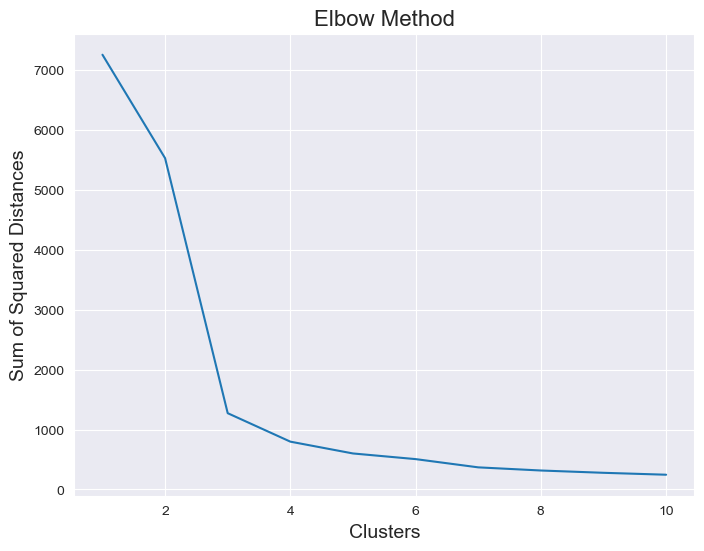

In [177]:
# Use the Elbow method to define the optimal number of clusters for kmeans clustering
max_iter = 1000
sumsquares = []
number_clusters = range(1,11)
for i in number_clusters:
    kmeans = KMeans(n_clusters = i, max_iter = max_iter, n_init = 'auto')
    kmeans.fit(datasvd)
    sumsquares.append(kmeans.inertia_)
plt.figure(figsize = (8,6))
plt.plot(number_clusters, sumsquares)
plt.xlabel('Clusters', fontsize = 14)
plt.ylabel('Sum of Squared Distances', fontsize = 14)
plt.title('Elbow Method', fontsize = 16)
plt.show()

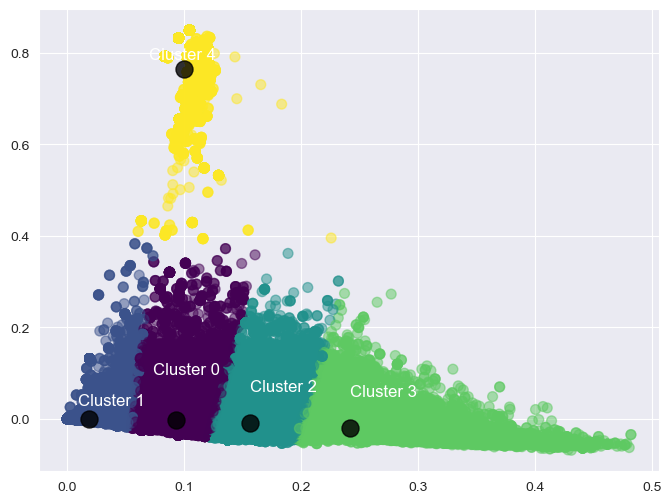

In [204]:
n_clusters = 5
clf = KMeans(n_clusters = n_clusters,init = 'random', max_iter = max_iter, tol = 0.0001, algorithm = 'lloyd', n_init = 'auto', random_state = 42)
fittedkmeans = clf.fit_predict(datasvd)
centroids = clf.cluster_centers_

# A diagram showing the clusters
plt.figure(figsize = (8,6))
plt.scatter(datasvd[:,0], datasvd[:,1], c = fittedkmeans, s = 50, cmap = 'viridis', alpha = 0.5)
plt.scatter(centroids[:, 0], centroids[:, 1], s = 150, c = 'black', alpha = 0.8)
plt.annotate('Cluster 0', xy = (centroids[0][0], centroids[0][1]), xytext = (centroids[0][0] - 0.02, centroids[0][1] + 0.10), color = 'white', fontsize = 12)
plt.annotate('Cluster 1', xy = (centroids[1][0], centroids[1][1]), xytext = (centroids[1][0] - 0.01, centroids[1][1] + 0.03), color = 'white', fontsize = 12)
plt.annotate('Cluster 2', xy = (centroids[2][0], centroids[2][1]), xytext = (centroids[2][0] + 0.00, centroids[2][1] + 0.07), color = 'white', fontsize = 12)
plt.annotate('Cluster 3', xy = (centroids[3][0], centroids[3][1]), xytext = (centroids[3][0] + 0.00, centroids[3][1] + 0.07), color = 'white', fontsize = 12)
plt.annotate('Cluster 4', xy = (centroids[4][0], centroids[4][1]), xytext = (centroids[4][0] - 0.03, centroids[4][1] + 0.02), color = 'white', fontsize = 12)

plt.show()